In [1]:
import os
os.chdir('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from ptflops import get_model_complexity_info

from torch.utils.data import random_split
from torch.utils.data import TensorDataset, DataLoader
from utils.Trainer import ModelTrainer
from models.models import BasicLSTM

device = "cuda" if torch.cuda.is_available() else "cpu"
from utils.datasets import EMG_dataset

In [2]:
skeleton_path = "M:/Datasets/shock_walk/Videos/skeletons/"
emg_path = "M:/Datasets/shock_walk/processed/"

skeleton_files = [skeleton_path + f for f in os.listdir(skeleton_path)]
emg_files = [emg_path + f for f in os.listdir(emg_path)]

summary_csv = pd.DataFrame({"EMG PATH" : emg_files, "SKEL PATH": skeleton_files, "FRAMES": [1800] * len(skeleton_files)})
summary_csv.to_csv("emg_skel.csv", index=False)

In [3]:
os.getcwd()

'C:\\Users\\gmald\\JupyterLab\\class\\biomed\\shock_walk'

In [4]:
# class BasicLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(BasicLSTM, self).__init__()
        
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.output_size = output_size
        
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size*4)
#         self.Drop = nn.Dropout(0.3)
        
#     def forward(self, x):
#         # Initialize hidden state with zeros
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
#         # Initialize cell state with zeros
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
#         out, _ = self.lstm(x, (h0, c0))
        
#         out = self.Drop(out)
#         out = self.fc(out[:, -1, :])
#         out = out.view(-1, 4, self.output_size)  # reshape the output to [batch_size, output_size, 4]
#         out = out.permute(0, 2, 1)
        
#         return out

In [5]:
def train_test_model(model, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=False):
    Trainer = ModelTrainer(model, nn.MSELoss(), torch.optim.Adam(model.parameters(), lr=lr), nn.MSELoss(), "Regression",  device, 0, noPrint=noPrint)
    t0 = datetime.now()
    Trainer.fit(trainLoader, validateLoader, EPOCHS)
    t1 = datetime.now()
    Trainer.Test_Model(testLoader)
    
    if not noPrint:
        print("\nTest Loss:", Trainer.Metrics["Test Loss"], "\nTime to Train:", t1 - t0)
        Trainer.Graph_Metrics()
    
    # macs, params = get_model_complexity_info(Trainer.model, (24, 4), as_strings=True, print_per_layer_stat=False, verbose=True)
    Trainer.model.to("cpu")
    
    return Trainer, None # (macs, params)

In [6]:
dataset = EMG_dataset("emg_skel.csv", lag=60, n_ahead=12)
X, Y = dataset.__getitem__(0)
print(X.shape, Y)

torch.Size([60, 28]) tensor([[0.0448, 0.0398, 0.1313, 0.2611],
        [0.0559, 0.0545, 0.2640, 0.0798],
        [0.0980, 0.0818, 0.1578, 0.1104],
        [0.0539, 0.0243, 0.1253, 0.0902],
        [0.0619, 0.0488, 0.1726, 0.1543],
        [0.0263, 0.0394, 0.1901, 0.2260],
        [0.0288, 0.0394, 0.1593, 0.2705],
        [0.0521, 0.0243, 0.1342, 0.4410],
        [0.0311, 0.0243, 0.1402, 0.2657],
        [0.0221, 0.0697, 0.0766, 0.2943],
        [0.0288, 0.0588, 0.1371, 0.2776],
        [0.0486, 0.0364, 0.1459, 0.2515]])


torch.Size([12, 30, 28]) torch.Size([12, 10, 4])


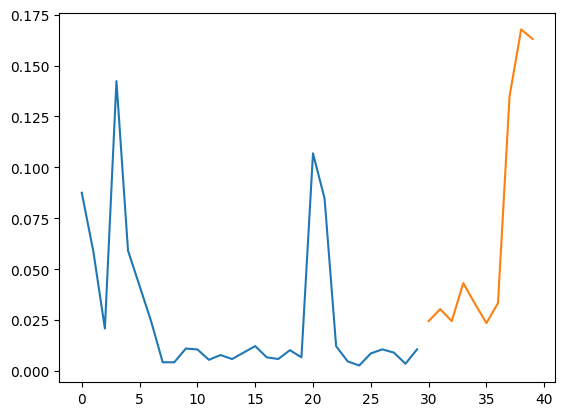

In [7]:
dataset = EMG_dataset("emg_skel.csv", lag=30, n_ahead=10)

batch_size = 12

train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.7, 0.1, 0.2])
testLoader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=True)


for X, Y in testLoader:
    print(X.shape, Y.shape)
    
    y_range = range(len(X[0][:, 0]), len(X[0][:, 0]) + len(Y[0][:, 0]))
    # First Batch
    plt.plot(X[0][:, 0])
    plt.plot(y_range, Y[0][:, 0])
    break

100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.12it/s]


EPOCH: 1
Training Loss: 0.017242864373473457  | Validation Loss: 0.014640222313719971


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.11it/s]


EPOCH: 2
Training Loss: 0.014533466055051776  | Validation Loss: 0.013910773304121046


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:58<00:00, 43.51it/s]


EPOCH: 3
Training Loss: 0.013730514209019475  | Validation Loss: 0.013355280881701926


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.34it/s]


EPOCH: 4
Training Loss: 0.013300842688432348  | Validation Loss: 0.013029815556801227


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.16it/s]


EPOCH: 5
Training Loss: 0.012949409193522941  | Validation Loss: 0.012701790854690104


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 42.90it/s]


EPOCH: 6
Training Loss: 0.012790153920868165  | Validation Loss: 0.012516419635451213


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.33it/s]


EPOCH: 7
Training Loss: 0.01244769583992808  | Validation Loss: 0.012230151303731698


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.18it/s]


EPOCH: 8
Training Loss: 0.012169569257297055  | Validation Loss: 0.011973461088006275


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.25it/s]


EPOCH: 9
Training Loss: 0.011918372534110962  | Validation Loss: 0.011811470776562876


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:58<00:00, 43.64it/s]


EPOCH: 10
Training Loss: 0.011628630770701243  | Validation Loss: 0.011674282443011814


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:01<00:00, 42.01it/s]


EPOCH: 11
Training Loss: 0.01131594154322001  | Validation Loss: 0.011075589736055694


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.42it/s]


EPOCH: 12
Training Loss: 0.010943673488045098  | Validation Loss: 0.01080307649062789


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:58<00:00, 43.58it/s]


EPOCH: 13
Training Loss: 0.010587792292478184  | Validation Loss: 0.01038699834264957


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:01<00:00, 41.44it/s]


EPOCH: 14
Training Loss: 0.010169761071713038  | Validation Loss: 0.009890313437893702


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.28it/s]


EPOCH: 15
Training Loss: 0.009827680002903783  | Validation Loss: 0.009558138964134356


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.21it/s]


EPOCH: 16
Training Loss: 0.009409864339505854  | Validation Loss: 0.00914071917620155


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.14it/s]


EPOCH: 17
Training Loss: 0.00902178693351593  | Validation Loss: 0.00863825219330614


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:02<00:00, 41.05it/s]


EPOCH: 18
Training Loss: 0.008624608594438777  | Validation Loss: 0.008177582235443494


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.15it/s]


EPOCH: 19
Training Loss: 0.008296766288540054  | Validation Loss: 0.007816081861546644


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.20it/s]


EPOCH: 20
Training Loss: 0.007964289881416713  | Validation Loss: 0.0074868221057969725


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:03<00:00, 40.39it/s]


EPOCH: 21
Training Loss: 0.00764409219818919  | Validation Loss: 0.007106940752423143


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:02<00:00, 41.03it/s]


EPOCH: 22
Training Loss: 0.00734951119261522  | Validation Loss: 0.00685826756697077


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.23it/s]


EPOCH: 23
Training Loss: 0.007060093235679444  | Validation Loss: 0.006456448730177751


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:02<00:00, 41.02it/s]


EPOCH: 24
Training Loss: 0.006770180276441589  | Validation Loss: 0.00605373972790869


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.37it/s]


EPOCH: 25
Training Loss: 0.006500247480615503  | Validation Loss: 0.005797040474294033


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.46it/s]


EPOCH: 26
Training Loss: 0.006245311549445669  | Validation Loss: 0.0055075571231533865


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.25it/s]


EPOCH: 27
Training Loss: 0.005968524496563368  | Validation Loss: 0.005205681247443813


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.38it/s]


EPOCH: 28
Training Loss: 0.005727661898004832  | Validation Loss: 0.004847126138683317


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.20it/s]


EPOCH: 29
Training Loss: 0.005436523191004638  | Validation Loss: 0.00454713778928105


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.35it/s]


EPOCH: 30
Training Loss: 0.005191979173173236  | Validation Loss: 0.004151710317335637


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.17it/s]


EPOCH: 31
Training Loss: 0.004968430976451233  | Validation Loss: 0.003931945541934478


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.09it/s]


EPOCH: 32
Training Loss: 0.004719863135536699  | Validation Loss: 0.0036069884089301326


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.46it/s]


EPOCH: 33
Training Loss: 0.0045159608598241245  | Validation Loss: 0.0033574234659349603


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.35it/s]


EPOCH: 34
Training Loss: 0.004351124145628621  | Validation Loss: 0.003225425388016903


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:01<00:00, 41.89it/s]


EPOCH: 35
Training Loss: 0.004241278858269072  | Validation Loss: 0.0030899069247239497


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.15it/s]


EPOCH: 36
Training Loss: 0.004108429586995185  | Validation Loss: 0.0028429283339870275


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.33it/s]


EPOCH: 37
Training Loss: 0.003980255384935283  | Validation Loss: 0.0027147163941502084


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:01<00:00, 41.76it/s]


EPOCH: 38
Training Loss: 0.003880964844113192  | Validation Loss: 0.0025707428348034985


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.21it/s]


EPOCH: 39
Training Loss: 0.0038026308727548263  | Validation Loss: 0.0025222575338303597


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.77it/s]


EPOCH: 40
Training Loss: 0.003749407167411487  | Validation Loss: 0.002454852525459486


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.55it/s]


EPOCH: 41
Training Loss: 0.0037037466334238545  | Validation Loss: 0.00240455076989162


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:01<00:00, 41.47it/s]


EPOCH: 42
Training Loss: 0.0036537069432313342  | Validation Loss: 0.0022820040529050764


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:58<00:00, 43.53it/s]


EPOCH: 43
Training Loss: 0.0035963145205856273  | Validation Loss: 0.002212072244264206


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.07it/s]


EPOCH: 44
Training Loss: 0.003558753396857517  | Validation Loss: 0.0021785954470246297


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.50it/s]


EPOCH: 45
Training Loss: 0.003507330710101723  | Validation Loss: 0.0021692680826852205


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:01<00:00, 41.70it/s]


EPOCH: 46
Training Loss: 0.003463609629571162  | Validation Loss: 0.0020694590303082555


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:58<00:00, 43.61it/s]


EPOCH: 47
Training Loss: 0.0034600229563614563  | Validation Loss: 0.0020076862973483324


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.41it/s]


EPOCH: 48
Training Loss: 0.0034307696816921786  | Validation Loss: 0.0019718799993842435


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:58<00:00, 43.54it/s]


EPOCH: 49
Training Loss: 0.0033866102410132813  | Validation Loss: 0.0019332787988844457


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.66it/s]


EPOCH: 50
Training Loss: 0.0033510056337726964  | Validation Loss: 0.0019828176242616584


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.10it/s]


EPOCH: 51
Training Loss: 0.0033422439220536647  | Validation Loss: 0.0018779722496623564


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:01<00:00, 41.61it/s]


EPOCH: 52
Training Loss: 0.003301929912194653  | Validation Loss: 0.001837838869522851


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.12it/s]


EPOCH: 53
Training Loss: 0.0032831264362170897  | Validation Loss: 0.0018063561063975462


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:03<00:00, 40.24it/s]


EPOCH: 54
Training Loss: 0.003260309234178793  | Validation Loss: 0.0017077127135008553


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:02<00:00, 41.07it/s]


EPOCH: 55
Training Loss: 0.0032250290418828842  | Validation Loss: 0.0017773360792707337


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.25it/s]


EPOCH: 56
Training Loss: 0.00322316888549097  | Validation Loss: 0.0017033108719117047


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.24it/s]


EPOCH: 57
Training Loss: 0.0031974641232521655  | Validation Loss: 0.0017053233391392153


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:01<00:00, 42.03it/s]


EPOCH: 58
Training Loss: 0.0031872557664459136  | Validation Loss: 0.0016656975853142687


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.44it/s]


EPOCH: 59
Training Loss: 0.003135879442012674  | Validation Loss: 0.0016509477456407343


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.35it/s]


EPOCH: 60
Training Loss: 0.003127767147792392  | Validation Loss: 0.001576255130986315


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:58<00:00, 43.56it/s]


EPOCH: 61
Training Loss: 0.003120496361204403  | Validation Loss: 0.0015913218924996496


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.64it/s]


EPOCH: 62
Training Loss: 0.0031158079477197577  | Validation Loss: 0.0015896113606218036


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.41it/s]


EPOCH: 63
Training Loss: 0.0030876646305600932  | Validation Loss: 0.001554775342810899


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:02<00:00, 41.31it/s]


EPOCH: 64
Training Loss: 0.0030802241409085707  | Validation Loss: 0.001523538100868159


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.29it/s]


EPOCH: 65
Training Loss: 0.003050649707023465  | Validation Loss: 0.001458591784252874


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.41it/s]


EPOCH: 66
Training Loss: 0.0030483141497762915  | Validation Loss: 0.0014761503494334501


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.22it/s]


EPOCH: 67
Training Loss: 0.0030239268690768527  | Validation Loss: 0.0014416357083309554


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.46it/s]


EPOCH: 68
Training Loss: 0.0030117062703943235  | Validation Loss: 0.0014158102592684288


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.56it/s]


EPOCH: 69
Training Loss: 0.0029820140542710627  | Validation Loss: 0.0014469971557081822


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.18it/s]


EPOCH: 70
Training Loss: 0.002987717898200833  | Validation Loss: 0.0014232687998819355


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.28it/s]


EPOCH: 71
Training Loss: 0.0029696221263839037  | Validation Loss: 0.0013484778623375788


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 42.80it/s]


EPOCH: 72
Training Loss: 0.0029552054403634196  | Validation Loss: 0.001349835650714962


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.54it/s]


EPOCH: 73
Training Loss: 0.0029412007926559467  | Validation Loss: 0.0013395429952691845


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:58<00:00, 43.58it/s]


EPOCH: 74
Training Loss: 0.0029401589466808895  | Validation Loss: 0.0013271489793470267


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.23it/s]


EPOCH: 75
Training Loss: 0.0029198344511004986  | Validation Loss: 0.0012733164017865236


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:01<00:00, 41.56it/s]


EPOCH: 76
Training Loss: 0.0029116147507981982  | Validation Loss: 0.0013137163165499956


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.37it/s]


EPOCH: 77
Training Loss: 0.002917829758079848  | Validation Loss: 0.0012780758501499973


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:58<00:00, 43.63it/s]


EPOCH: 78
Training Loss: 0.002887694472271077  | Validation Loss: 0.0012182725518269399


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.44it/s]


EPOCH: 79
Training Loss: 0.0028645656480485475  | Validation Loss: 0.0011627146925355944


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:58<00:00, 43.70it/s]


EPOCH: 80
Training Loss: 0.0028523297704332504  | Validation Loss: 0.001247918664836845


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.60it/s]


EPOCH: 81
Training Loss: 0.002834050480949714  | Validation Loss: 0.0011342551972531797


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.42it/s]


EPOCH: 82
Training Loss: 0.0028367980846730296  | Validation Loss: 0.0011910266675593012


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.66it/s]


EPOCH: 83
Training Loss: 0.0028346157627326066  | Validation Loss: 0.0011106578253174064


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:58<00:00, 43.58it/s]


EPOCH: 84
Training Loss: 0.002817693942476443  | Validation Loss: 0.0011383860212768496


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:02<00:00, 40.96it/s]


EPOCH: 85
Training Loss: 0.0028087465111768495  | Validation Loss: 0.0010961361444486706


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:00<00:00, 42.65it/s]


EPOCH: 86
Training Loss: 0.0027980664375818246  | Validation Loss: 0.0010903909249226143


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 43.42it/s]


EPOCH: 87
Training Loss: 0.002793912549423693  | Validation Loss: 0.001099268777507842


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:58<00:00, 43.60it/s]


EPOCH: 88
Training Loss: 0.0027831683334806315  | Validation Loss: 0.0011042881195880067


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [01:01<00:00, 41.86it/s]


EPOCH: 89
Training Loss: 0.002782586494826773  | Validation Loss: 0.0010938561134159626


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:58<00:00, 43.51it/s]


EPOCH: 90
Training Loss: 0.0027759047042354244  | Validation Loss: 0.0011087985474892894


100%|██████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:59<00:00, 42.79it/s]


EPOCH: 91
Training Loss: 0.0027796009784570907  | Validation Loss: 0.00109578320063138
Stopping Model Early

Test Loss: 0.0010847529778333141 
Time to Train: 1:54:02.464306
None


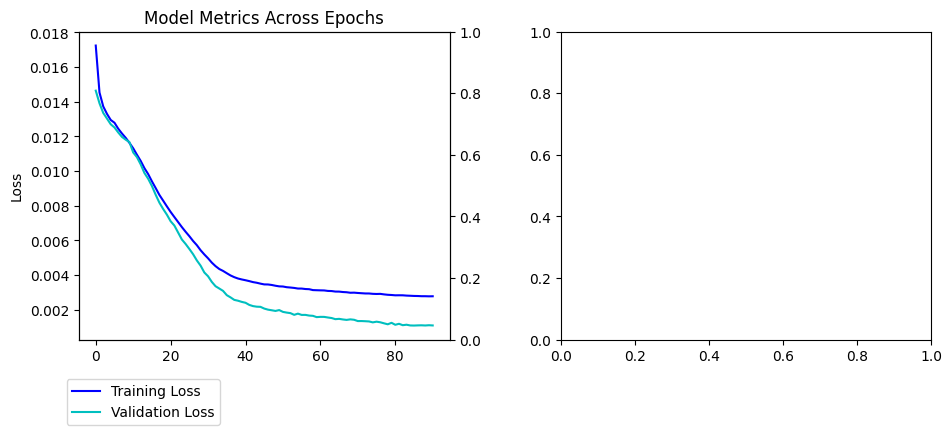

In [8]:
input_size = 28
hidden_size = 128
num_layers = 5
output_size = train_dataset.dataset.n_ahead

trainLoader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, shuffle=False)
validLoader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4, shuffle=False)


model = BasicLSTM(input_size, hidden_size, num_layers, output_size)

Trainer, mp = train_test_model(model, 0.0007, trainLoader, validLoader, testLoader, EPOCHS=300, noPrint=False)
print(mp)

(10,) torch.Size([12, 10, 4]) torch.Size([30, 28])


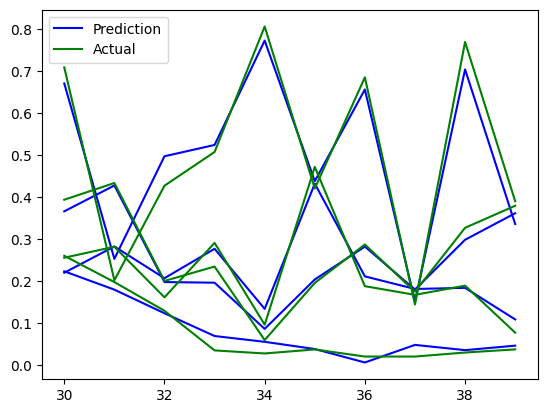

In [15]:
# model_path = "./models/pre-trained/EMG_32.pt"
# model = BasicLSTM(input_size, hidden_size, num_layers, output_size)
# model.load_state_dict(torch.load(model_path))

for X, Y in testLoader:
    X = X
    Y = Y
    pred = model(X).detach().numpy()
    
    print(pred[0,:,0].shape, Y.shape, X[0].shape)
    
    # Assume Extension 
    y_range = range(len(X[0]), len(X[0])+validLoader.dataset.dataset.n_ahead)

    
    # plt.plot(X[0,:].detach().cpu())
    plt.plot(y_range, pred[0,:], 'b')
    plt.plot(y_range, Y[0,:], 'g')
    
    # Create Line2D objects representing the lines
    line_pred = plt.Line2D([], [], color='blue')
    line_Y = plt.Line2D([], [], color='green')

    # Create the legend using the Line2D objects and labels
    plt.legend([line_pred, line_Y], ["Prediction", "Actual"])
    
    break

In [10]:
torch.save(Trainer.model.state_dict(), "models/EMG_32_Full2.pt")

In [11]:
cwd = os.getcwd()
cwd

'C:\\Users\\gmald\\JupyterLab\\class\\biomed\\shock_walk'